# Document Vectors and Visualization

In [2]:
from google.colab import files

uploaded = files.upload()
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
!pip install -r requirements.txt
!pip install paramiko

KeyboardInterrupt: ignored

## Word Vectors

Upload `datafile.json` and `requirements.txt` then install requirements; don't run this block unless you need to (it takes a while).

Now that the necessary files are uploaded, load the necessary packages. If the word embeddings aren't loaded yet, install them (this also takes a long time, but this code should check if it's necessary).

In [4]:
import sys
import json
import re
# import spacy
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from gensim.parsing.preprocessing import remove_stopwords
import numpy
import matplotlib.pyplot as plt
import random


try:
    open("datafile.json", "r")
except FileNotFoundError as fnfe:
    print("Upload the data file. (See the above block)")
with open("datafile.json", "r") as datafile:
    DATASET = json.load(datafile)
random.shuffle(DATASET)  # shuffle the dataset to better train vectors

try:
    import en_core_web_lg
except ModuleNotFoundError as mnfe:
    !python -m spacy download en_core_web_lg
    import en_core_web_lg
    EMBEDDING = en_core_web_lg.load()

    100% |████████████████████████████████| 852.3MB 76.8MB/s 
  Running setup.py install for en-core-web-lg ... done

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_lg -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en_core_web_lg

    You can now load the model via spacy.load('en_core_web_lg')



Define functions needed to process data into vectors. Also define `N`, the number of records to use.

In [0]:
N = 500

def download_dataset():
    DATASET = dynamo_db.get_dataset("project_summaries")
    for doc in DATASET:
        doc["_id"] = int(doc["_id"])
    with open("datafile.json", "w") as datafile:
        json.dump(DATASET, datafile)


def get_words(text):
    """
    thanks jackie
    """
    text = text.lower()
    wordlist = text.split()
    clean_list = []
    for word in wordlist:
        # only get words (no digits)
        if not word.isdigit() and not re.match(r"[^\w]", word):
            clean_list.append(word)
    return " ".join(clean_list)


def naive_doc_vectors():
    return [
        EMBEDDING(remove_stopwords(get_words(doc["summary"]))).vector
        for doc in DATASET[: N - 1]
    ]


def vector_labels():
    return [doc["theme"] for doc in DATASET[: N - 1]]


def construct_reduced_X(vectors):
    X = numpy.vstack(vectors)
    scaler = StandardScaler()
    scaler.fit_transform(X)
    ev = PCA().fit(X).explained_variance_ratio_
    pca = PCA(n_components=2)
    pca.fit_transform(X)
    return X, ev

In [0]:
    # get word embeddings
    vectors = naive_doc_vectors()

    # construct feature matrix reduced with PCA
    X, ev = construct_reduced_X(vectors)

Visualize the results of adding word vectors to describe documents.

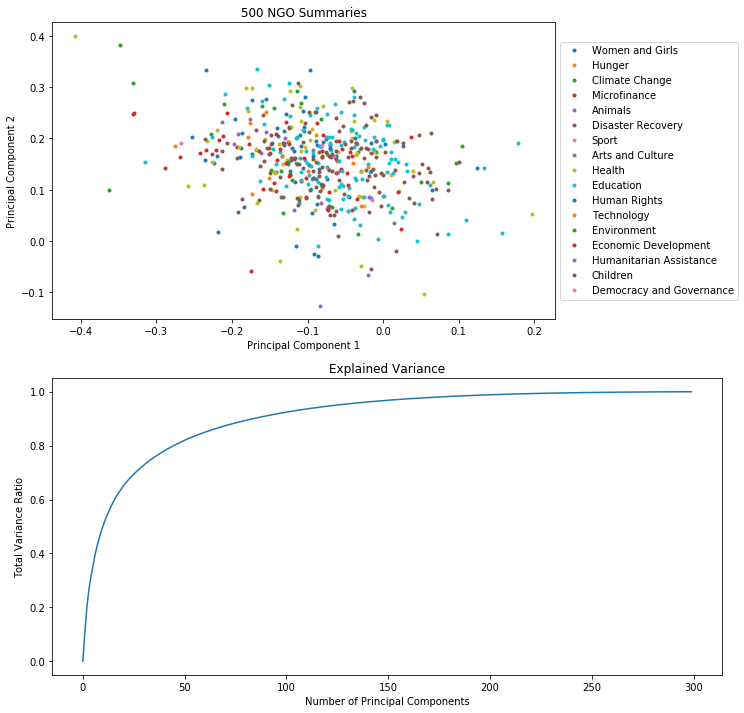

In [8]:
    labels = numpy.array(vector_labels())
    fig, ax = plt.subplots(2)
    labelset = set(labels)
    for label in labelset:
        ax[0].plot(
            X[labels == label, 0],
            X[labels == label, 1],
            label=label,
            marker=".",
            linestyle="",
        )
    ax[0].set_title("{} NGO Summaries".format(N))
    ax[0].set_xlabel("Principal Component 1")
    box = ax[0].get_position()
    ax[0].set_position([box.x0, box.y0, box.width * 0.75, box.height])
    ax[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax[0].set_ylabel("Principal Component 2")
#     print([numpy.sum(ev[:n]) for n in range(10)])  # print explained variance values
    ax[1].plot([numpy.sum(ev[:n]) for n in range(len(ev))])
    ax[1].set_title("Explained Variance")
    ax[1].set_xlabel("Number of Principal Components")
    ax[1].set_ylabel("Total Variance Ratio")
    fig.set_size_inches(12, 12)

## Document Vectors

In [1]:
import pandas as pd
import os
import gensim
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from gensim.models import Doc2Vec
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string
import operator

LabeledSentence = gensim.models.doc2vec.TaggedDocument

def get_documents():
  documents = []
  id = 0
  for doc in DATASET:
    document = preprocess_string(remove_stopwords(get_words(doc["summary"])))
    documents.append(LabeledSentence(document, [id]))
    id += 1
  return documents

def train_doc2vec(documents):
  model = Doc2Vec(documents, vector_size=100, window=10, min_count=500, workers=1000, dm=1, alpha=0.025, min_alpha=0.001)
  model.train(documents, total_examples=model.corpus_count, epochs=3, start_alpha=0.002, end_alpha=-0.016)
  return model

/usr/local/lib/python3.6/dist-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [0]:
documents = get_documents()
model = train_doc2vec(documents)

## Cluster using K-means

In [0]:
def cluster(model, n_clusters):
  kmeans_model = KMeans(n_clusters=n_clusters)
  X = kmeans_model.fit(model.docvecs.vectors_docs)
  labels=kmeans_model.labels_.tolist()
  l = kmeans_model.fit_predict(model.docvecs.vectors_docs)
  return labels, kmeans_model

labels, kmeans_model = cluster(model, 14)

In [66]:

from pprint import pprint

centroids = kmeans_model.cluster_centers_
pprint([model.wv.similar_by_vector(centroid, topn=10) for centroid in centroids])

[[('flood', -0.0577937588095665),
  ('relief', -0.0758005753159523),
  ('emerg', -0.0979560911655426),
  ('anim', -0.10649202764034271),
  ('disast', -0.11477824300527573),
  ('death', -0.1209002435207367),
  ('ill', -0.13571138679981232),
  ('patient', -0.1639089584350586),
  ('earthquak', -0.16432322561740875),
  ('diseas', -0.1663617044687271)],
 [('english', -0.1914425790309906),
  ('read', -0.22795738279819489),
  ('orphanag', -0.2349415123462677),
  ('sew', -0.2402753233909607),
  ('dream', -0.25144243240356445),
  ('classroom', -0.2543644607067108),
  ('librari', -0.2567744553089142),
  ('uniform', -0.2585199475288391),
  ('music', -0.2660965621471405),
  ('colleg', -0.26716938614845276)],
 [('help', 0.8136264681816101),
  ('live', 0.783096969127655),
  ('project', 0.7747853994369507),
  ('order', 0.7446085214614868),
  ('provid', 0.7378194332122803),
  ('support', 0.7167547941207886),
  ('seek', 0.7165842056274414),
  ('ensur', 0.7141017913818359),
  ('requir', 0.70428508520126

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [67]:
def cluster_percentages(labels):
  doc_nums = []
  cluster_percentages = []
  for i in range(14):
    doc_nums.append(0)
    cluster_percentages.append({})
    
  for i, label in enumerate(labels):
    doc_nums[label] += 1
    if not DATASET[i]["theme"] in cluster_percentages[label]:
      cluster_percentages[label][DATASET[i]["theme"]] = 0
    cluster_percentages[label][DATASET[i]["theme"]] += 1
  
  for i in range(14):
    for theme in cluster_percentages[i]:
      cluster_percentages[i][theme] /= doc_nums[i]
  
  return cluster_percentages

cluster_percentages = cluster_percentages(labels)
  
for i in range(len(cluster_percentages)):
  print("Cluster ", i)
  cluster_percentages[i] = sorted(cluster_percentages[i].items(), key=operator.itemgetter(1))
  print(cluster_percentages[i])
  print()

Cluster  0
[('LGBTQAI+', 0.0030211480362537764), ('Democracy and Governance', 0.0036925142665323934), ('Humanitarian Assistance', 0.004028197381671702), ('Sport', 0.005706612957368244), ('Arts and Culture', 0.006377979187646861), ('Microfinance', 0.00906344410876133), ('Technology', 0.010070493454179255), ('Climate Change', 0.022155085599194362), ('Hunger', 0.03356831151393085), ('Human Rights', 0.036925142665323936), ('Environment', 0.048674051695199734), ('Animals', 0.05807317891910037), ('Economic Development', 0.0755287009063444), ('Education', 0.08828465928163813), ('Disaster Recovery', 0.09936220208123532), ('Women and Girls', 0.10305471634776771), ('Health', 0.18462571332661967), ('Children', 0.20778784827123195)]

Cluster  1
[('Humanitarian Assistance', 0.0018075011296882061), ('LGBTQAI+', 0.0022593764121102574), ('Sport', 0.0072300045187528245), ('Arts and Culture', 0.014008133755083597), ('Technology', 0.015363759602349751), ('Disaster Recovery', 0.016267510167193855), ('Micr

In [72]:
def get_document(labels):
  label_set = set()
  document_list = []
  for i in range(14):
    document_list.append('')
  for i, label in enumerate(labels):
    if not label in label_set:
      label_set.add(label)
      document_list[label] = DATASET[i]["summary"]
  return document_list

doc_list = get_document(labels)

for i, doc in enumerate(doc_list):
  print("Cluster ", i)
  print(doc)

Cluster  0
Relief International is working with Afghan teachers to integrate human rights education into their classrooms, with a curriculum that emphasizes women's and children's rights.
Cluster  1
SEDS is an independent, student-based organization which promotes the exploration and development of space. SEDS pursues this mission by educating people about the benefits of space, by supporting a network of interested students, by providing an opportunity for members to develop their leadership skills, and inspiring people through our involvement in space-related projects.
Cluster  2
For five years, Lead Us Today has empowered over 3,000 Zimbabwean high school students with the leadership skills to mobilize their communities in addressing their own challenges through implementing collectively designed development projects. In our next phase of growth, we are expanding our program from 40 to 100 schools, and empowering an additional 4,000 students. Through our intervention, we are creatin

Reduce the document vectors to 2 dimensions using PCA. Label each document using the K-means determined cluster label.

In [0]:
ev = PCA().fit(model.docvecs.vectors_docs).explained_variance_ratio_
pca = PCA(n_components=2).fit(model.docvecs.vectors_docs)
datapoint = pca.transform(model.docvecs.vectors_docs)

Plot 12 k-means clusters

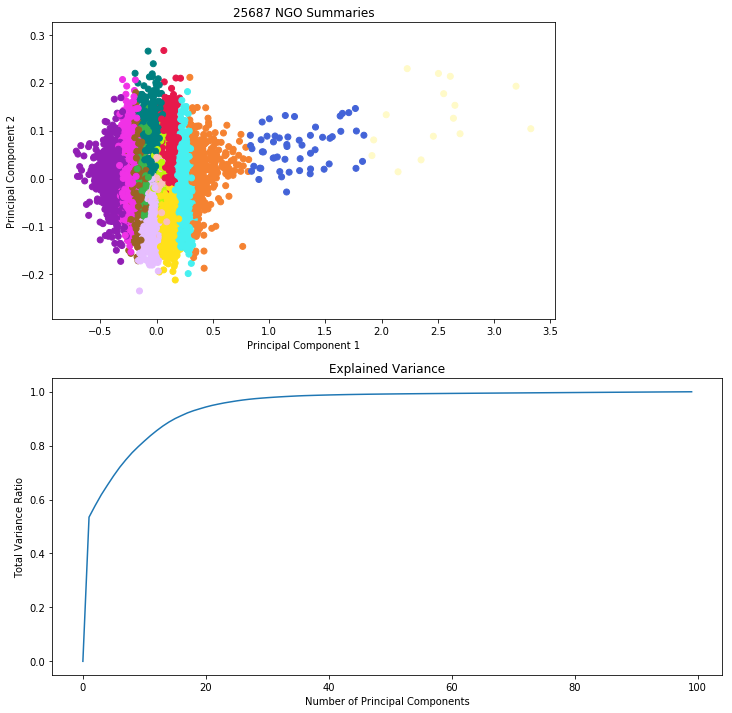

In [70]:
fig, ax = plt.subplots(2)
label1 = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8']
color = [label1[i] for i in labels]
ax[0].scatter(datapoint[:, 0], datapoint[:, 1], c=color)
ax[0].set_title("{} NGO Summaries".format(len(DATASET)))
ax[0].set_xlabel("Principal Component 1")
box = ax[0].get_position()
ax[0].set_position([box.x0, box.y0, box.width * 0.75, box.height])
# ax[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax[0].set_ylabel("Principal Component 2")
ax[1].plot([numpy.sum(ev[:n]) for n in range(len(ev))])
ax[1].set_title("Explained Variance")
ax[1].set_xlabel("Number of Principal Components")
ax[1].set_ylabel("Total Variance Ratio")
fig.set_size_inches(12, 12)

Plot 18 k-means clusters

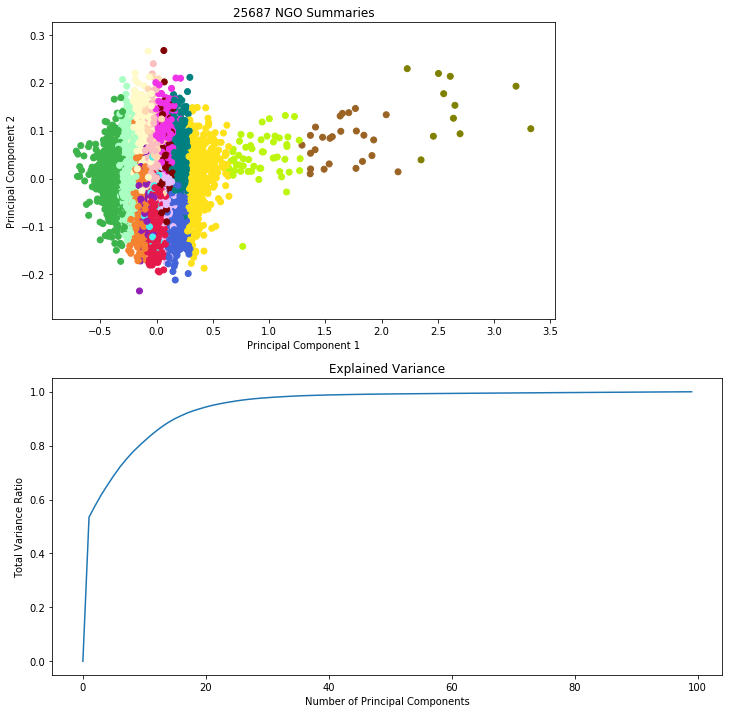

In [73]:
labels, kmeans_mode = cluster(model, 18)

fig, ax = plt.subplots(2)
label1 = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']
color = [label1[i] for i in labels]
ax[0].scatter(datapoint[:, 0], datapoint[:, 1], c=color)
ax[0].set_title("{} NGO Summaries".format(len(DATASET)))
ax[0].set_xlabel("Principal Component 1")
box = ax[0].get_position()
ax[0].set_position([box.x0, box.y0, box.width * 0.75, box.height])
# ax[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax[0].set_ylabel("Principal Component 2")
ax[1].plot([numpy.sum(ev[:n]) for n in range(len(ev))])
ax[1].set_title("Explained Variance")
ax[1].set_xlabel("Number of Principal Components")
ax[1].set_ylabel("Total Variance Ratio")
fig.set_size_inches(12, 12)

## Plot Document Vectors

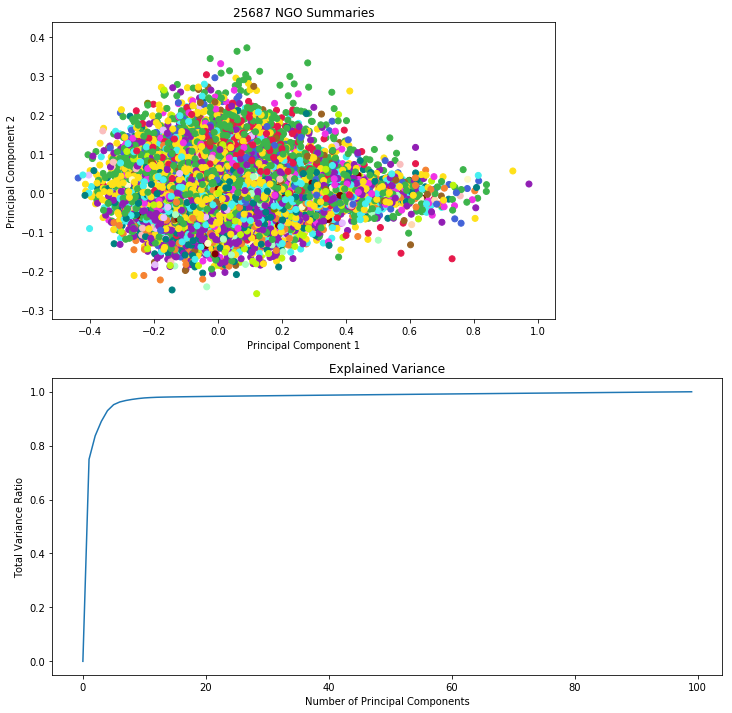

In [13]:
theme_labels = numpy.array([doc["theme"] for doc in DATASET])
label2 = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']
ind = 0
labeldict = dict()
for label in theme_labels:
  if label not in labeldict:
    labeldict[label] = ind
    ind += 1
    
labelset = set(theme_labels)
color = [label2[labeldict[l]] for l in theme_labels]
fig, ax = plt.subplots(2)

ax[0].scatter(datapoint[:, 0], datapoint[:, 1], c=color)
ax[0].set_title("{} NGO Summaries".format(len(DATASET)))
ax[0].set_xlabel("Principal Component 1")
box = ax[0].get_position()
ax[0].set_position([box.x0, box.y0, box.width * 0.75, box.height])
ax[0].set_ylabel("Principal Component 2")
#     print([numpy.sum(ev[:n]) for n in range(10)])  # print explained variance values
ax[1].plot([numpy.sum(ev[:n]) for n in range(len(ev))])
ax[1].set_title("Explained Variance")
ax[1].set_xlabel("Number of Principal Components")
ax[1].set_ylabel("Total Variance Ratio")
fig.set_size_inches(12, 12)